In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import pylab as pl

%pylab inline
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib


Populating the interactive namespace from numpy and matplotlib


In [30]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.urlretrieve(url, "file.gz")
#os.system("mv " + "file.gz" + os.getenv("PUIDATA"))
!unzip file.gz
!mv geo_export_7b751d10-c62f-4a20-9332-194fd3952ac0.dbf /nfshome/ak6948/PUIdata/
!mv geo_export_7b751d10-c62f-4a20-9332-194fd3952ac0.shp /nfshome/ak6948/PUIdata/
!mv geo_export_7b751d10-c62f-4a20-9332-194fd3952ac0.shx /nfshome/ak6948/PUIdata/
!mv geo_export_7b751d10-c62f-4a20-9332-194fd3952ac0.prj /nfshome/ak6948/PUIdata/

Archive:  file.gz
  inflating: geo_export_480af77c-8c1d-4f9b-b7ce-29081820d1b0.dbf  
  inflating: geo_export_480af77c-8c1d-4f9b-b7ce-29081820d1b0.shp  
  inflating: geo_export_480af77c-8c1d-4f9b-b7ce-29081820d1b0.shx  
  inflating: geo_export_480af77c-8c1d-4f9b-b7ce-29081820d1b0.prj  
mv: cannot stat 'geo_export_7b751d10-c62f-4a20-9332-194fd3952ac0.dbf': No such file or directory
mv: cannot stat 'geo_export_7b751d10-c62f-4a20-9332-194fd3952ac0.shp': No such file or directory
mv: cannot stat 'geo_export_7b751d10-c62f-4a20-9332-194fd3952ac0.shx': No such file or directory
mv: cannot stat 'geo_export_7b751d10-c62f-4a20-9332-194fd3952ac0.prj': No such file or directory


In [68]:
pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" + "geo_export_7b751d10-c62f-4a20-9332-194fd3952ac0.shp")
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [3]:
pumashp.crs

{'init': 'epsg:4326'}

In [70]:
!curl https://raw.githubusercontent.com/fedhere/choroplethNYC/master/choroplethNYC.py > choroplethNYC.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7747  100  7747    0     0  69321      0 --:--:-- --:--:-- --:--:-- 69792


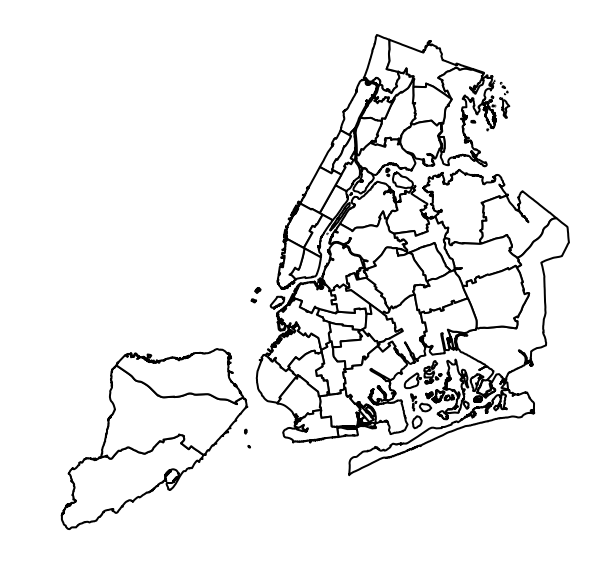

In [4]:
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

In [5]:
import requests
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [6]:
affkeys = np.array(list(aff1y['variables'].keys()))
affkeys


array(['B24122_210E', 'B27009_033E', 'B19101A_005E', ..., 'B25125_016E',
       'B24122_325E', 'B05007_083E'], 
      dtype='<U14')

In [7]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL')]

In [8]:
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [9]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [46]:
import io
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=2cb1da66180c1500411b64f7e2a22728992c0d9d"
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [47]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=2cb1da66180c1500411b64f7e2a22728992c0d9d"
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [69]:
pumaBB['B28002_001E']= pumaPP['B28002_001E']
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,78.150656


In [70]:
pumaBB['pcBB'] = (pumaBB['B28002_004E']/pumaBB['B28002_001E'])*100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,78.150656


In [71]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.drop(0, inplace=True)
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,36,81.7,0.2
2,3600100,80.6,2.6
3,3600200,75.7,2.2
4,3600300,79.8,2.6
5,3600401,81.4,2.4


In [51]:
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)
type(bbpc['GCT_STUB.target-geo-id2'][1])

numpy.int64

In [52]:
bbpc["gid"] = bbpc['GCT_STUB.target-geo-id2'].apply(pd.to_numeric) - 3600000
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,36,81.7,0.2,-3599964
2,3600100,80.6,2.6,100
3,3600200,75.7,2.2,200
4,3600300,79.8,2.6,300
5,3600401,81.4,2.4,401


In [57]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,diff
count,145.000000,145.000000
mean,81.845478,0.026217
std,7.063369,0.014480
min,54.932945,0.000178
25%,77.770257,0.012252
50%,82.826141,0.027230
75%,87.305077,0.039090
max,93.404143,0.049872


In [72]:
pumashp.puma=pd.to_numeric(pumashp.puma)
pumashp = pumashp.merge(pumaBB, left_on='puma', right_on='public use microdata area', how='left')
pumashp.head()


,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN,55953,78.778618


(<matplotlib.figure.Figure at 0x7f0cf7daada0>,
 <matplotlib.colorbar.Colorbar at 0x7f0cfdecd6d8>)

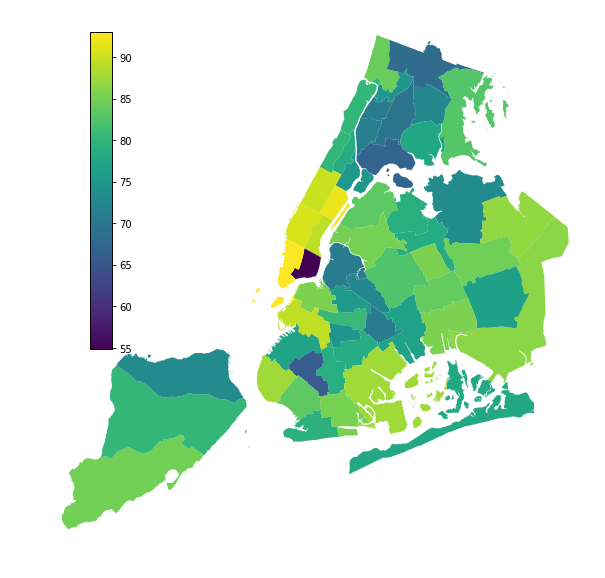

In [73]:
cp.choroplethNYC(pumashp, "pcBB", kind='continuous', cmap="viridis")

In [50]:
!curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv > linkNYClocations.csv
!mv linkNYClocations.csv /nfshome/ak6948/PUIdata/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75571  100 75571    0     0   299k      0 --:--:-- --:--:-- --:--:--  299k


In [131]:
linkNYC = pd.read_csv("/nfshome/ak6948/PUIdata/linkNYClocations.csv")
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [132]:
linkNYC.shape

(1414, 5)

In [133]:
linkNYC=linkNYC.drop(['Unnamed: 0'], axis=1)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [134]:
linkNYC.shape

(1414, 4)

In [135]:
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)"
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)"
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)"
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)"
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)"


In [136]:
import shapely
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [137]:
from fiona.crs import from_epsg
linkNYC = gpd.GeoDataFrame(linkNYC,geometry='geometry')
linkNYC.crs = from_epsg(4326)
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [138]:
linkNYC.crs

{'init': 'epsg:4326', 'no_defs': True}

In [139]:
linkNYC['date'] = pd.to_datetime(linkNYC.date_link_)
linkNYC['today'] = pd.datetime.now().date()
linkNYC['days'] = pd.to_datetime(linkNYC['today']).subtract(pd.to_datetime(linkNYC['date']))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry,date,today,days
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753),2017-07-01,2018-10-24,480 days
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938),2017-07-01,2018-10-24,480 days
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439),2017-07-01,2018-10-24,480 days
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042),2017-04-28,2018-10-24,544 days
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133),2017-03-31,2018-10-24,572 days


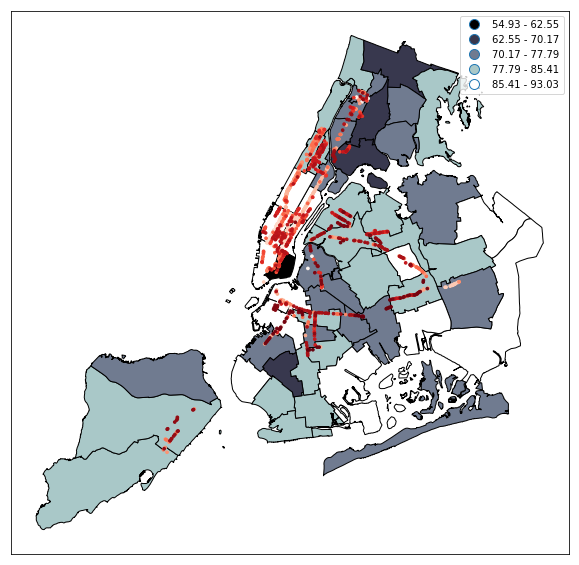

In [168]:
ax = pl.figure(figsize=(10, 10)).add_subplot(111)

set1 = pumashp.plot(column="pcBB", ax=ax, cmap="bone", scheme='Equal_Interval', k=5, edgecolor='black', legend=True)
set2 = linkNYC.plot(c=linkNYC.days, ax=ax, cmap='Reds', markersize=7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [146]:
population = "B00001_001E"
url = "https://api.census.gov/data/2016/acs/acs1?get=" + population +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=2cb1da66180c1500411b64f7e2a22728992c0d9d"
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [155]:
pumashp1 = pumashp.to_crs(epsg=2263)
linkNYC1 = linkNYC.to_crs(epsg=2263)
linkpp = gpd.sjoin(pumashp1,linkNYC1).groupby('puma')['link_site'].count().reset_index()
linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [161]:
pumashpPop = pumashp.merge(pumaPop, left_on='puma', right_on='public use microdata area', how='left')
pumashpPop.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME_x,state_x,public use microdata area_x,Unnamed: 4_x,B28002_001E,pcBB,B00001_001E,NAME_y,state_y,public use microdata area_y,Unnamed: 4_y
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN


In [162]:
pumashplc = pumashpPop.merge(linkpp, on='puma', how='left')
pumashplc['linkNYCp100p'] = pumashplc['link_site']/pumashplc['B00001_001E'] *100
pumashplc["linkNYCp100p"].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


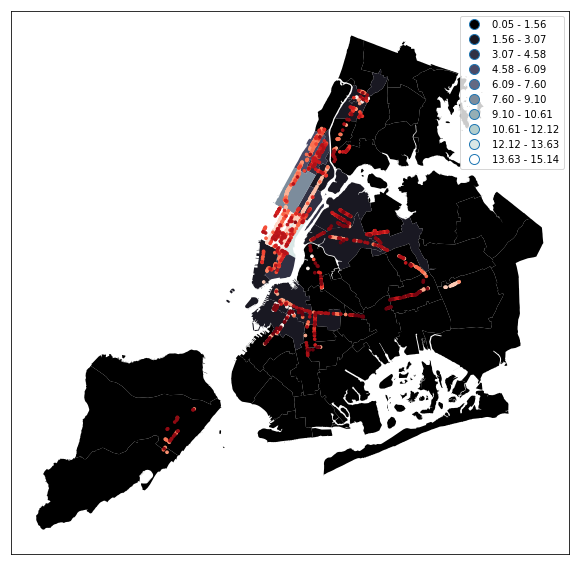

In [172]:
ax = pl.figure(figsize=(10, 10)).add_subplot(111)

pumashplc.plot(column="linkNYCp100p", ax=ax, cmap="bone", scheme='Equal_Interval', k=10, legend=True)
linkNYC.plot(c=linkNYC.days, ax=ax, cmap='Reds', markersize=7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)